#  InfoGAN
https://arxiv.org/abs/1606.03657 

Information Maximizing GAN, o InfoGAN para abreviar es una red neural adversarial capaz de aprender **representaciones desenredadas** de las características maximizando la información mutua entre un subconjunto de variables latentes ($z$) y las observaciones ($x$) calculando una cota inferior de la misma.  
  
Como se ha visto, CGAN y ACGAN están facultados a inducir al generador para producir un dígito(o salida) específica concatenando un vector one-hot al vector de ruido, esto indica que estamos **desenredando** ciertas características de nuestro vector **enredado**.  
  
InfoGAN introduce una nueva forma de desenredar aún más los datos: Concatenar componentes que permitan variar ciertas características en los datos generados. En el caso particular de *MNIST* exiten componentes que varían el grosor del trazo y la inclinación del dígito.


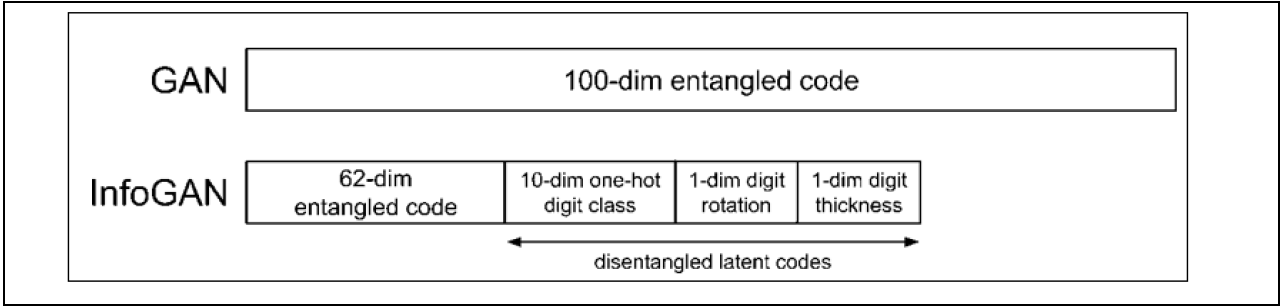

In [3]:
from IPython.display import Image
Image(r'images/GANvsInfoGAN.png', retina = True)

## Función de pérdida  
Debido a que adicionamos características modificables a nuestro modelo, dichas representaciones desenredadas también deben ser optimizadas, es por esto que la salida del generador varía de la siguiente manera 
$$\mathcal{G}(\textbf{z})=\mathcal{G}(z,c)$$  

donde $\textbf{z}$ se enecuentra compuesto de dos componentes:
* Ruido enredado incomprensible similar al vector de  ruido $z$ de la GAN.
* Códigos latentes $c_1, c_2 \cdots, c_L$ que representan los codigos desenredados interpretables. 

Por simplicidad se asume la independencia de los códigos latentes, i.e.
$$p(c_1,c_2,\cdots,c_L)=\prod_{i=1}^{L}p(c_i) $$  
  
Ahora, la idea clave de la InfoGAN es forzar a la GAN a no ignorar el código latente $c$, lo cual se logra **maximizando la información mutua** entre $c$ y $\mathcal{G}(z,c)$, es decir maximizar la "cantidad de información" aprendida por conocimiento de $\mathcal{G}(z,c)$ sobre las variables latentes $c$:  

$$I(c;\mathcal{G}(z,c))= H(c)-H(c|\mathcal{G}(z,c))$$  

Así la función de pérdida del modelo GAN  

$$\underset{\mathcal{G}}{\min}\underset{\mathcal D}{\max} V (\mathcal{D},\mathcal{G}) = \mathbb{E}_{x\sim P_{data}} [logD(x)] + \mathbb{E}_{z\sim noise}[log (1 − D(G(z)))]$$  
Se transforma en la pérdida con un factor de regularización $\lambda$

$$\underset{\mathcal{G}}{\min}\underset{\mathcal D}{\max}
V_I (\mathcal{D},\mathcal{G}) = V (\mathcal{D},\mathcal{G}) − \lambda I(c;\mathcal{G}(z, c))$$  

El problema radica cuando se desea estimar $I(c;\mathcal{G}(z, c))$ ya que requiere un conocimiento a posteriori de la distribución de los datos $P(c|x)$. La solución a este problema se encuentra estimando una cota inferior variacional de la información mutua mediante una distribución auxiliar **$ \mathcal{Q}(c|x)$** modelada a partir de una Red Neuronal

$$L_I(\mathcal{G}, \mathcal{Q})= E_{x\sim\mathcal{G}(z,c)}[~\mathbb{E}_{c'\sim P(c|x)}[\log \mathcal{Q}(c'|x)]~]+H(c)  \leq I(c;\mathcal{G}(z,c))$$  

Por tanto la función de pérdida final resulta 

$$\underset{\mathcal{G}}{\min}\underset{\mathcal D}{\max}
V_I (\mathcal{D},\mathcal{G}) = V (\mathcal{D},\mathcal{G}) − \lambda L_I(\mathcal{G}, \mathcal{Q})$$ 

El entrenamiento del generador a través de la información mutua se logra mediante el uso de un nuevo modelo $Q$. El nuevo modelo comparte todos los mismos pesos que el modelo discriminador para interpretar una imagen de entrada, pero a diferencia del modelo discriminador que predice si la imagen es real o falsa, el modelo auxiliar predice los códigos de latentes que se usaron para generar la imagen.

Ambos modelos se usan para actualizar el modelo generador, primero para mejorar la probabilidad de generar imágenes que engañen al modelo discriminador y segundo para mejorar la información mutua entre los códigos latentes usados para generar una imagen y la predicción de los códigos de control del modelo $Q$.


## Arquitectura

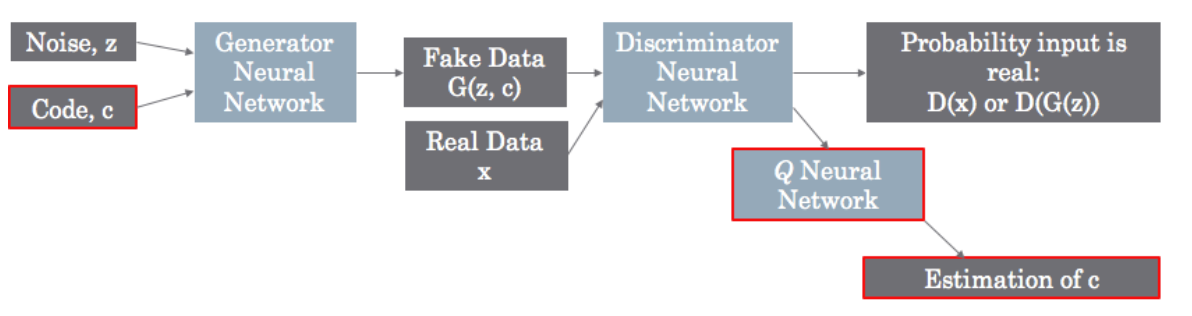

In [2]:
Image(r'images/InfoGan-structure.png', retina = True)

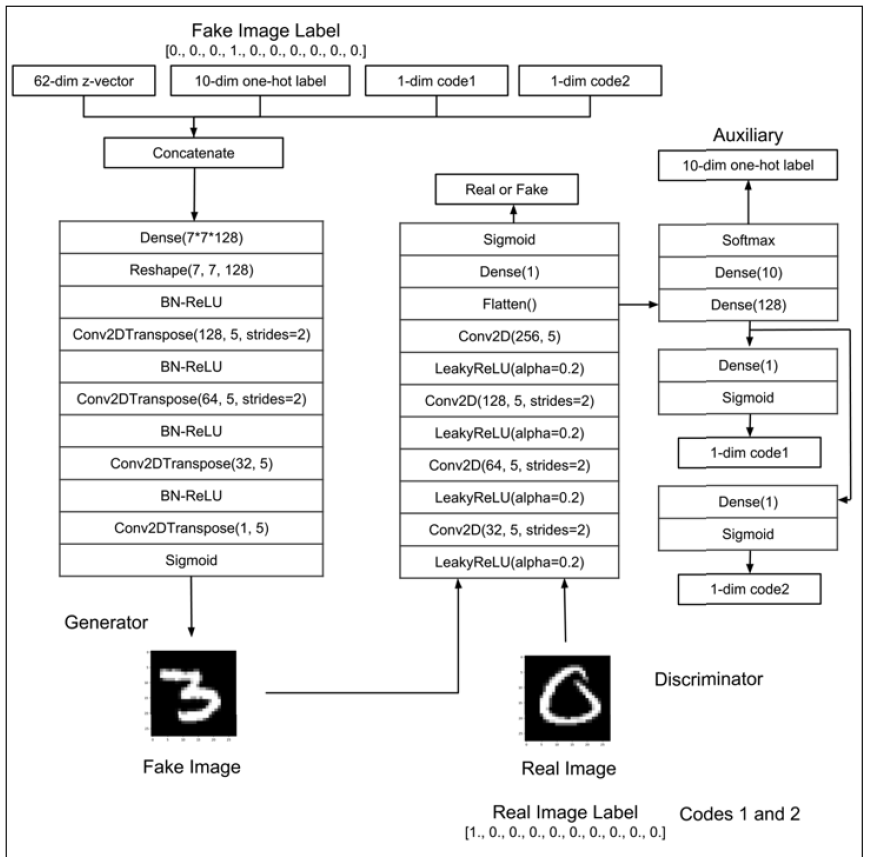

In [5]:
Image(r'images/arq_infogan.png', retina = True)

## Implementación en Keras

In [4]:
'''Trains infoGAN on MNIST using Keras
This version of infoGAN is similar to DCGAN. The difference mainly
is that the z-vector of geneerator is conditioned by a one-hot label
to produce specific fake images. The discriminator is trained to
discriminate real from fake images and predict the corresponding
one-hot labels.
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Chen, Xi, et al. "Infogan: Interpretable representation learning by
information maximizing generative adversarial nets." 
Advances in Neural Information Processing Systems. 2016.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import numpy as np
import argparse

import sys
sys.path.append("..")
from lib import gan


def train(models, data, params):
    """Train the Discriminator and Adversarial networks
    Alternately train discriminator and adversarial networks by batch.
    Discriminator is trained first with real and fake images,
    corresponding one-hot labels and continuous codes.
    Adversarial is trained next with fake images pretending 
    to be real, corresponding one-hot labels and continous codes.
    Generate sample images per save_interval.
    # Arguments
        models (Models): Generator, Discriminator, Adversarial models
        data (tuple): x_train, y_train data
        params (tuple): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and their one-hot labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = \
            params
    # the generator image is saved every 500 steps
    save_interval = 500
    # code standard deviation
    code_std = 0.5
    # noise vector to see how the generator output 
    # evolves during training
    noise_input = np.random.uniform(-1.0,
                                    1.0,
                                    size=[16, latent_size])
    # random class labels and codes
    noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    noise_code1 = np.random.normal(scale=code_std, size=[16, 1])
    noise_code2 = np.random.normal(scale=code_std, size=[16, 1])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_label, axis=1))
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images and 
        # corresponding labels from dataset 
        rand_indexes = np.random.randint(0,
                                         train_size,
                                         size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        #-------------------------------------------------
        # random codes for real images
        real_code1 = np.random.normal(scale=code_std,
                                      size=[batch_size, 1])
        real_code2 = np.random.normal(scale=code_std, 
                                      size=[batch_size, 1])
        #--------------------------------------------------
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_code1 = np.random.normal(scale=code_std,
                                      size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=code_std, 
                                      size=[batch_size, 1])
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        fake_images = generator.predict(inputs)

        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        codes1 = np.concatenate((real_code1, fake_code1))
        codes2 = np.concatenate((real_code2, fake_code2))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0

        # train discriminator network, 
        # log the loss and label accuracy
        outputs = [y, labels, codes1, codes2]
        # metrics = ['loss', 'activation_1_loss', 'label_loss',
        # 'code1_loss', 'code2_loss', 'activation_1_acc',
        # 'label_acc', 'code1_acc', 'code2_acc']
        # from discriminator.metrics_names
        metrics = discriminator.train_on_batch(x, outputs)
        fmt = "%d: [dis: %f, bce: %f, ce: %f, mi: %f, mi:%f, acc: %f]"
        log = fmt % (i, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[6])

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0 and
        # corresponding one-hot label or class + random codes
        # since the discriminator weights are frozen 
        # in adversarial network only the generator is trained
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        #--------------------------------------------------
        fake_code1 = np.random.normal(scale=code_std,
                                      size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=code_std, 
                                      size=[batch_size, 1])
        #--------------------------------------------------
        # label fake images as real
        y = np.ones([batch_size, 1])

        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator 
        # input of the adversarial for classification
        # log the loss and label accuracy
        inputs = [noise, fake_labels, fake_code1, fake_code2]
        outputs = [y, fake_labels, fake_code1, fake_code2]
        metrics  = adversarial.train_on_batch(inputs, outputs)
        fmt = "%s [adv: %f, bce: %f, ce: %f, mi: %f, mi:%f, acc: %f]"
        log = fmt % (log, metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[6])

        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            gan.plot_images(generator,
                            noise_input=noise_input,
                            noise_label=noise_label,
                            noise_codes=[noise_code1, noise_code2],
                            show=False,
                            step=(i + 1),
                            model_name=model_name)
   
        # save the model after training the generator
        # the trained generator can be reloaded for
        # future MNIST digit generation
        if (i + 1) % (2 * save_interval) == 0:
            generator.save(model_name + ".h5")

#---------------------------------------------------------------
def mi_loss(c, q_of_c_given_x):
    """ Mutual information, Equation 5 in [2],
        assuming H(c) is constant
    """
    # mi_loss = -c * log(Q(c|x))
    return -K.mean(K.sum(c * K.log(q_of_c_given_x + K.epsilon()), 
                                   axis=1))
#---------------------------------------------------------------

def build_and_train_models(latent_size=100, train_steps = 40000, batch_size = 32):
    """Load the dataset, build InfoGAN discriminator,
    generator, and adversarial models.
    Call the InfoGAN train routine.
    """
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    # train labels
    num_labels = len(np.unique(y_train))
    y_train = to_categorical(y_train)

    model_name = "infogan_mnist"
    # network parameters
    
    
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )
    code_shape = (1, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    # call discriminator builder with 4 outputs: 
    # source, label, and 2 codes
    discriminator = gan.discriminator(inputs,
                                      num_labels=num_labels,
                                      #--------------------#
                                      num_codes=2)
                                      #--------------------#
    # [1] uses Adam, but discriminator converges easily with RMSprop
    optimizer = RMSprop(learning_rate=lr, decay=decay)
    # loss functions: 1) probability image is real 
    # (binary crossentropy)
    # 2) categorical cross entropy image label,
    #-----------------------------------
    # 3) and 4) mutual information loss
    loss = ['binary_crossentropy', 
            'categorical_crossentropy', 
            mi_loss, 
            mi_loss]
    # lamda or mi_loss weight is 0.5
    loss_weights = [1.0, 1.0, 0.5, 0.5]
    #------------------------------------
    discriminator.compile(loss=loss,
                          loss_weights=loss_weights,
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    labels = Input(shape=label_shape, name='labels')
    code1 = Input(shape=code_shape, name="code1")
    code2 = Input(shape=code_shape, name="code2")
    # call generator with inputs, 
    # labels and codes as total inputs to generator
    generator = gan.generator(inputs,
                              image_size,
                              labels=labels,
                              codes=[code1, code2])
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(learning_rate=lr*0.5, decay=decay*0.5)
    discriminator.trainable = False
    # total inputs = noise code, labels, and codes
    inputs = [inputs, labels, code1, code2]
    adversarial = Model(inputs,
                        discriminator(generator(inputs)),
                        name=model_name)
    # same loss as discriminator
    adversarial.compile(loss=loss,
                        loss_weights=loss_weights,
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, 
              latent_size, 
              train_steps, 
              num_labels, 
              model_name)
    train(models, data, params)

In [4]:
%%time
build_and_train_models(latent_size=100)

Se han truncado las últimas 5000 líneas del flujo de salida.
35007: [dis: -0.944985, bce: 0.666754, ce: 0.002623, mi: -1.607155, mi:-1.621568, acc: 1.000000] [adv: -1.539767, bce: 0.854405, ce: 0.252009, mi: -2.868932, mi:-2.423429, acc: 0.968750]
35008: [dis: -0.679428, bce: 0.571326, ce: 0.044984, mi: -1.238878, mi:-1.352600, acc: 0.968750] [adv: -3.465710, bce: 0.964723, ce: 0.000004, mi: -5.549492, mi:-3.311382, acc: 1.000000]
35009: [dis: -0.295116, bce: 0.688258, ce: 0.000294, mi: -1.335860, mi:-0.631476, acc: 1.000000] [adv: -1.730016, bce: 1.146789, ce: 0.013402, mi: -2.986857, mi:-2.793557, acc: 1.000000]
35010: [dis: -1.023526, bce: 0.620986, ce: 0.000813, mi: -1.428035, mi:-1.862616, acc: 1.000000] [adv: -1.659536, bce: 1.247275, ce: 0.003485, mi: -2.663464, mi:-3.157128, acc: 1.000000]
35011: [dis: -0.409377, bce: 0.593740, ce: 0.002654, mi: -0.161230, mi:-1.850313, acc: 1.000000] [adv: -2.946486, bce: 0.686908, ce: 0.000018, mi: -3.224391, mi:-4.042435, acc: 1.000000]
3501

In [5]:
import zipfile
import os

zip = zipfile.ZipFile('images.zip', 'w')

for im in os.listdir('infogan_mnist'):
    dir = os.path.join('infogan_mnist', im)
    zip.write(dir, compress_type=zipfile.ZIP_DEFLATED)

zip.close()

In [6]:
import imageio

images = []
for filename in os.listdir('infogan_mnist'):
    dir = os.path.join('infogan_mnist', filename)
    images.append(imageio.imread(dir))
imageio.mimsave('infogan_mnist.gif', images)

## Generador de imágenes

In [ ]:
def test_generator(generator, params, latent_size=100):
    label, code1, code2, p1, p2 = params
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    step = 0
    if label is None:
        num_labels = 10
        noise_label = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_label = np.zeros((16, 10))
        noise_label[:,label] = 1
        step = label

    code_std = 2
    if code1 is None:
        noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p1:
            a = np.linspace(-code_std, code_std, 16)
            a = np.reshape(a, [16, 1])
            noise_code1 = np.ones((16, 1)) * a
        else:
            noise_code1 = np.ones((16, 1)) * code1
        #print(noise_code1)

    if code2 is None:
        noise_code2 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p2:
            a = np.linspace(-code_std, code_std, 16)
            a = np.reshape(a, [16, 1])
            noise_code2 = np.ones((16, 1)) * a
        else:
            noise_code2 = np.ones((16, 1)) * code2
        #print(noise_code2)

    gan.plot_images(generator,
                    noise_input=noise_input,
                    noise_label=noise_label,
                    noise_codes=[noise_code1, noise_code2],
                    show=True,
                    step=step,
                    model_name="test_outputs")

In [6]:
from keras.models import load_model
generator = load_model(r'infogan_mnist.h5')

In [ ]:
import numpy as np
x = np.linspace(-1,1,10)
for i in range(len(x)):
    test_generator(generator, [ 7 , x[i], 0, None, None], latent_size=100)